# Analyzing Ulysses with NLTK: Lestrygonians (Ch. 8)

## Part III: Tagging

<br />
<br />
<br />

### Table of Contents
* [Introduction](#intro)
* Tagging Words:
 * [Creating Word Tag DataFrame](#wordtagdf)
 * [Plotting Intermittencies of Words](#intermittencies)
 * [Analyzing Word Frequencies with FFT](#fft)
 * [Using Wavelets to Examine the Time-Frequency Domain](#wavelets)

<br />
<br />
<br />


## Introduction

(Here, I'll explain the approach we are using to tag individual words. Currently a regex-based approach that creates a DataFrame with one row per word. Next steps will be looking for multiple regex matches, and creating broader topical categories, like "death" or "body parts," potentially associated with lots of different words.)

(Also need to explain sentence tagging - not implemented yet, but this will utilize a similar approach, creating a dataframe with one sentence per row, and tagging each sentence with words, topics, etc.)

In [420]:
# In case we want to plot something:
%matplotlib inline 

# I'm from the future and I'm here to help
from __future__ import division

# The io module makes unicode easier to deal with
import io

def p():
    print "-"*20

In [421]:
file_contents = io.open('txt/08lestrygonians.txt','r').read()

In [422]:
import nltk, re
import numpy as np
import pandas as pd

# We're about to get plotted up in this business
import seaborn as sns
from matplotlib.pylab import *

<a name="wordtagdf"></a>
## Creating Word Tag DataFrame

In [423]:
words = nltk.word_tokenize(file_contents)
print len(words)

wdf = pd.DataFrame(columns=['WORD'],data=words)

def regex_to_column(label,regex,wdf):
    wdf[label] = wdf.apply( lambda x : len( re.findall(regex,x.values[0])), axis=1)

15153


Now we'll apply the `regex_to_column()` method to tag occurrences of particular regular expressions:

In [424]:
regex_to_column('pt verb', r'ed$', wdf)
regex_to_column('eye', r'^eye', wdf)
regex_to_column('Bloom', r'Bloom', wdf)
regex_to_column('God', r'God', wdf)
regex_to_column('knife', r'kni[fv]e', wdf)
regex_to_column('oo', r'oo', wdf)
regex_to_column('him', r'^hi[ms]$', wdf)
regex_to_column('and', r'^and$', wdf)
regex_to_column('is', r'^is$', wdf)
regex_to_column('blue', r'blue$', wdf)
regex_to_column('green', r'green$', wdf)

wdf['length'] = wdf.apply( lambda x : 1.0/len( x.values[0] ), axis=1)

In [425]:
colors = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple","aqua blue"])

<a name="intermittencies"></a>
## Plotting Intermittencies Between Words

Now that we have created vectors of 0s and 1s representing whether words in the chapter are a particular word, we can count up the number of 0s that occur, and examine the distribution. This will give us a sense of how often a particular word appears, and whether (and to what extent) those appearances are clustered together.



In [426]:
def plot_intermittency(key,words_df):
    counts =[]
    counter = 0
    for (ii,yy) in enumerate(words_df[key]):
        if yy>0:
            counts.append(counter)
            counter = 0
        else:
            counter += 1
            
    hist(counts,bins=20)
    
    xlabel('No. of Words Intermittency')
    ylabel('Count')
    title(key)
    show()

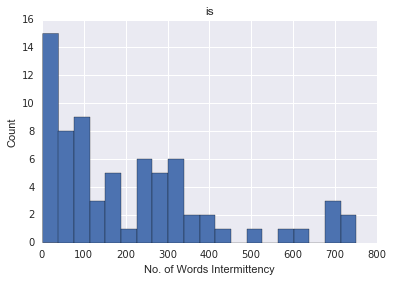

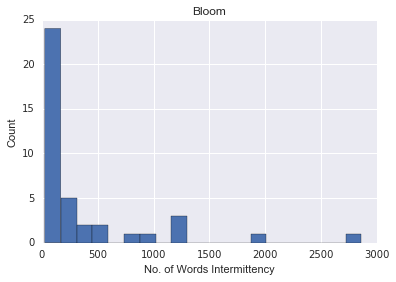

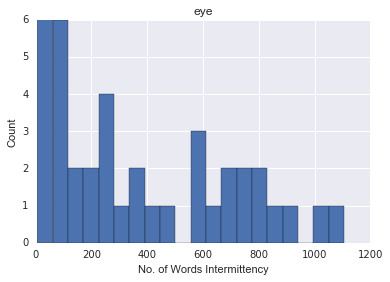

In [427]:
plot_intermittency('is',wdf)
plot_intermittency('Bloom',wdf)
plot_intermittency('eye',wdf)

<a name="fft"></a>
## Analyzing Word Frequencies with FFT

 we can take the Fourier transform of these variables to see the most common frequencies for occurrences of that word.

The Fourier transform will determine the coefficients of a large number of sine waves of various frequencies (in this case, the number of frequencies is equal to half the number of samples). These coefficients, called Fourier coefficients, can be plotted, and any frequencies that occur more commonly for a particular word will manifest as a large peak in the plot of Fourier coefficients.

In [428]:
def fft_column(key,words_df):
    n = len(words_df) # length of signal
    k = np.arange(n) 
    t = words_df.index.values
    y = words_df[key].values

    frq = k/n # two-sided frequency range
    frq = frq[range(int(n/2))] # one-sided frequency range

    Y = np.fft.ifft(y)#/n # fft computing and normalization
    Y = Y[range(int(n/2))] # one-sided

    return (frq, Y)

In [429]:
def fft_plots(key,words_df):
    (frq,Y) = fft_column(key,words_df)

    y = words_df[key]
    # Make a rug plot:
    # 0 where it is not the key word
    # 1 where it is the key word
    fig = figure(figsize=(10,4))
    
    ax1 = fig.add_subplot(111)
    
    ax1.plot(t,y,color=colors[0])
    ax1.set_xlabel('Word Location')
    ax1.set_ylabel('Amplitude')
    ax1.set_ylim([0,1.5])
    ax1.set_title('Rug Plot: '+str(key))
    
    # Make a freq domain plot:
    # FFT magnitude vs Frequency 
    fig = figure(figsize=(10,4))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.plot(frq, abs(Y), color=colors[1]) # plotting the spectrum
    ax2.set_xlabel('Freq (Hz)')
    ax2.set_ylabel('|Y(freq)|')
    ax1.set_title('FFT: '+str(key))    
    
    ax2.semilogx(frq, log(abs(Y)), 'o', color=colors[3]) # plotting the spectrum
    ax2.set_xlabel('Freq (Hz)')
    ax2.set_ylabel('|Y(freq)|')
    ax2.set_title('Log FFT: '+str(key))    
    

Now let's look at this plot for one of the most common words in the English language: "is". The first "rug" plot visualizes the occurrence vector (the vector of 0s and 1s that indicate if a word is the word "is").

The two plots below that are plots of the Fourier coefficients. The plot on the left shows the magnitude of the Fourier coefficients versus frequency, while the plot on the right shows the same quantity on a log-log plot.

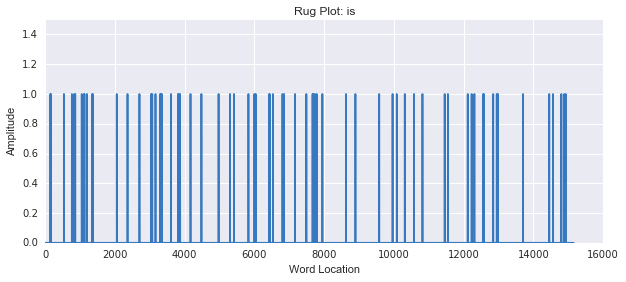

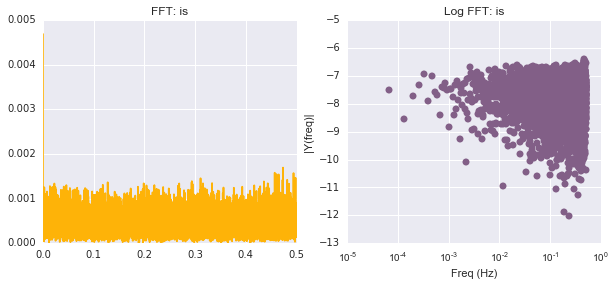

In [430]:
fft_plots('is',wdf)

Index([u'WORD', u'pt verb', u'eye', u'Bloom', u'God', u'knife', u'oo', u'him',
       u'and', u'is', u'blue', u'green', u'length'],
      dtype='object')


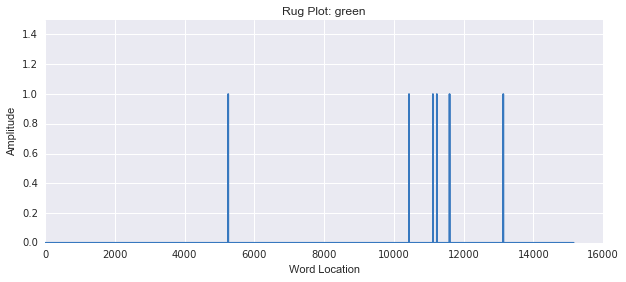

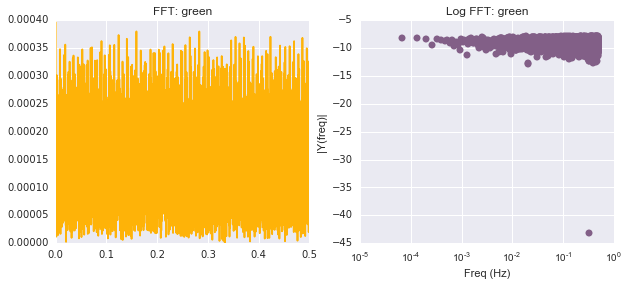

In [431]:
print wdf.columns
fft_plots('green',wdf)

<a name="wavelets"></a>
## Using Wavelets to Examine the Time-Frequency Domain

While the Fourier transform of the word occurrence vector gave some interesting results, they can be hard to interpret because they remove time information. A better approach would tell us about the frequency domain and the frequencies that occur, while also retaining information about when they occur. This would allow us to more easily spot when and how words are clustered throughout the chapter.

It turns out that the wavelet is a mathematical tool that can do precisely that - show us information about both the time and frequency domains.

--------------------
0.574058766243
0.0
0.00719229977021


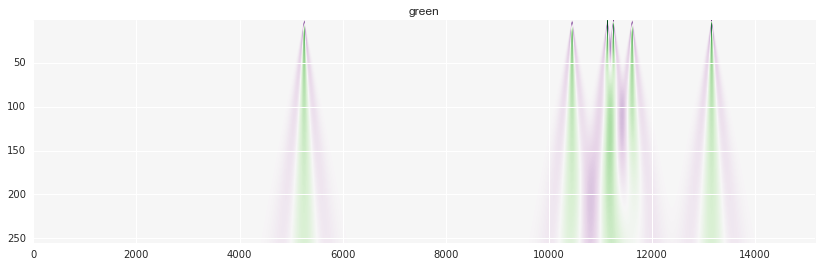

In [432]:
from scipy import signal

def wavelet_column(key,words_df):
    n = len(words_df) # length of signal
    k = np.arange(n) 
    t = words_df.index.values
    y = words_df[key].values

    frq = k/n # two-sided frequency range
    frq = frq[range(int(n/2))] # one-sided frequency range
    
    z = 8
    
    widths = np.arange(1, 2**z - 1)#31)
    cwtmatr = signal.cwt(y, signal.ricker, widths)
    
    p()
    key
    print abs(cwtmatr).max()
    print abs(cwtmatr).min()
    print abs(cwtmatr).mean()
    
    figure(figsize=(14,4))
    imshow(cwtmatr, extent=[0, n, 2**z - 1, 1], cmap='PRGn', aspect='auto',
               vmax=abs(cwtmatr).max()/2, vmin=-abs(cwtmatr).max()/2)
    title(key)

    #return (frq, Y)

#wavelet_column('but',wdf)
wavelet_column('green',wdf)
#wavelet_column('him',wdf)

There is a lot of information contained in this figure, so let's go through it one piece at a time.